In [1]:
#Required Libraries
import matplotlib.pyplot as plt 
import pandas as pd
import io
import math
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence,text


from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
import keras.backend as K

from sklearn.metrics import cohen_kappa_score

# Restart runtime using 'Runtime' -> 'Restart runtime...'
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

Using TensorFlow backend.


1.15.0


In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
!gsutil cp gs://cloud-training-demos/courses/machine_learning/deepdive/09_sequence/text_classification/glove.6B.200d.txt glove.6B.200d.txt

Copying gs://cloud-training-demos/courses/machine_learning/deepdive/09_sequence/text_classification/glove.6B.200d.txt...
/ [1 files][661.3 MiB/661.3 MiB]   24.4 MiB/s                                   
Operation completed over 1 objects/661.3 MiB.                                    


In [0]:
#Load the data and store in a data frame
def load_data():
  df = pd.read_csv(r'essays_and_scores.csv',encoding='latin-1')
  data = df[['essay_id','essay_set','essay','rater1_domain1','rater1_domain1','domain1_score']].copy()
  data = data.dropna() #drop all NaN values
  #print(data)
  #check details of the data
  print(data['essay'].apply(len).describe())
  return data


In [0]:
def visualize_data(data):
  x = [len(w.split()) for w in data['essay']]  #store no of words of each essay in a list

  n, bins, patches = plt.hist(x=x, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)  #histogram plot
  
  #plt.grid(axis='y', alpha=0.75)
  plt.xlabel('No. of words')
  plt.ylabel('Frequency')
  plt.title('essay length vs freq')
  maxfreq = n.max()
  
  # Set a clean upper y-axis limit.
  plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [0]:
def clean_data(data):

  #remove all punctuations
  data_ = [
      [(word.replace(",", "")
            .replace(".", "")
            .replace("(", "")
            .replace(")", "")
            .replace("@", "")
            .replace("?", "")
           .replace("!", "")
            .replace(":", ""))
      for word in row.lower().split()]
      for row in data['essay']]

  #restore words to sentences

  str1=""
  essay_d=[]
  for d in data_:
    #print(d)
    for i in d:
      str1 = str1 + i + " "
    essay_d.append(str1)
    str1=""

  #score = [data['rater1_domain1'] + data['rater1_domain1'] ] / data['domain1_score'] * 2 
  #score = score * 100
  new_data = pd.DataFrame(list(zip(essay_d,data['domain1_score'])),columns = ['Essay','Score'])

  return (new_data)
  

In [0]:
def generate_test_train(new_data):
  #shuffle the dataset before splitting
  new_data1 = shuffle(new_data)

  train = new_data1.sample(frac=0.8)
  new_data1.drop(train.index, axis=0, inplace=True)
  valid = new_data1.sample(frac=0.5)
  new_data1.drop(valid.index, axis=0, inplace=True)
  test = new_data1
  print(train.shape , test.shape , valid.shape )

  def return_data(df):
    return list(df['Essay']), np.array(df['Score'])


  # Apply it to the three splits
  train_essay, train_score = return_data(train)
  valid_essay, valid_score = return_data(valid)
  test_essay, test_score = return_data(test)
  print(train_essay[0], train_score[0])
  
  #return a tuple of values 
  return (train_essay,train_score,valid_essay,valid_score,test_essay,test_score)



In [0]:
def preprocess_data(train_essay,valid_esssay,test_essay):
  
  # Create a vocabulary from training corpus
  #tokenizer = text.Tokenizer(num_words=TOP_K)
  #tokenizer.fit_on_texts(train_essay)

  #word_index=tokenizer.word_index
  #print(word_index)

  # Preprocess the train, validation and test sets
  # Tokenize and pad sentences
  preproc_train = tokenizer.texts_to_sequences(train_essay)
  preproc_train = sequence.pad_sequences(preproc_train, maxlen=MAX_SEQUENCE_LENGTH)
  preproc_valid = tokenizer.texts_to_sequences(valid_essay)
  preproc_valid = sequence.pad_sequences(preproc_valid, maxlen=MAX_SEQUENCE_LENGTH)
  preproc_test = tokenizer.texts_to_sequences(test_essay)
  preproc_test = sequence.pad_sequences(preproc_test, maxlen=MAX_SEQUENCE_LENGTH)

  #return a tuple of values
  return (preproc_train,preproc_valid,preproc_test)

In [0]:
def get_embedding_matrix(word_index, embedding_path, embedding_dim):
  embedding_matrix_all = {}
  with open(embedding_path) as f:
    for line in f:  # Every line contains word followed by the vector value
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_matrix_all[word] = coefs

        
  # Prepare embedding matrix with just the words in our word_index dictionary
  num_words = min(len(word_index) + 1, TOP_K)
  embedding_matrix = np.zeros((num_words, embedding_dim))
  for word, i in word_index.items():
    if i >= TOP_K:
        continue
    embedding_vector = embedding_matrix_all.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
  
  return embedding_matrix

In [0]:
def build_model():
  # Create model instance
  model = Sequential()
  num_features = min(len(word_index) + 1, TOP_K)
  # Add embedding layer - GloVe embeddings
  model.add(Embedding(input_dim=num_features,
                output_dim=embedding_dim,
                input_length=MAX_SEQUENCE_LENGTH,
                weights=[get_embedding_matrix(word_index, 
                                embedding_path, embedding_dim)],
                trainable=True))



  #Add more layers

  model.add(LSTM(200, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 200], return_sequences=True))
  model.add(LSTM(64, recurrent_dropout=0.4))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='relu'))

  model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
  model.summary()

  return model



count    12977.000000
mean      1215.871234
std        958.321377
min          8.000000
25%        527.000000
50%        900.000000
75%       1670.000000
max       6098.000000
Name: essay, dtype: float64


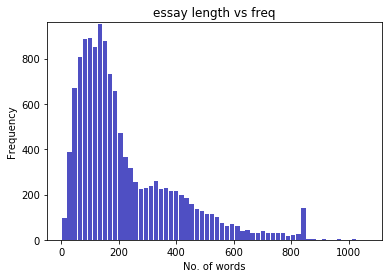

In [12]:
#Run the code 

data = load_data()
visualize_data(data)
new_data = clean_data(data)

In [14]:

train_essay,train_score,valid_essay,valid_score,test_essay,test_score = generate_test_train(new_data)

(10382, 2) (1297, 2) (1298, 2)
the features of the setting affect the cyclist by the mood the cyclist and what happens as he journeys in the desert to a town for example his mood changes when the old man asks him for a map and his attitude changes by cautiousness of the new of the new road he went on then terror when he thought he was gonna die ò i was gonna die and the birds would pick me cleanó then to pride when the old man asks for a map and the author says òi own a very good mapó but as he journeys to yosemite the setting changes when he goes to a desert type of place then goes a bait shop to rest then probably on his merry way to his destination  2.0


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
#Global Variables
# Maximum vocabulary size used for tokenization
TOP_K = 80000 
# Sentences will be truncated/padded to this length
MAX_SEQUENCE_LENGTH = 800

In [0]:

# Create a vocabulary from training corpus
tokenizer = text.Tokenizer(num_words=TOP_K)
tokenizer.fit_on_texts(train_essay)

In [0]:
preproc_train,preproc_valid,preproc_test = preprocess_data(train_essay,valid_essay,test_essay)


In [0]:
# Specify the hyperparameters
filters=64
dropout_rate=0.2
embedding_dim=200
kernel_size=3
pool_size=3
word_index=tokenizer.word_index    #initialized in preprocess func()
embedding_path = 'glove.6B.200d.txt'
embedding_dim=200   #the output dimension from the embedding layer to be fed to the next layer 

In [19]:
print(len(preproc_train[0]))
print(len(preproc_train[10]))

print(len(preproc_train))
print(len(preproc_test))
print(len(preproc_valid))

800
800
10382
1297
1298


In [21]:
model = build_model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 800, 200)          7925600   
_________________________________________________________________
lstm_3 (LSTM)                (None, 800, 200)          320800    
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                67840     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 8,314,305
Trainable params: 8,314,305
Non-trainable params: 0
_________________________________________________________________


In [35]:
H = model.fit(preproc_train,
         train_score,
         validation_data=(preproc_valid, valid_score),
         batch_size=128,
         epochs=10,
         verbose=1)

Train on 10382 samples, validate on 1298 samples
Epoch 1/10
10382/10382 [==============================] - 281s 27ms/step - loss: 16.7883 - mean_absolute_error: 2.1983 - val_loss: 9.0038 - val_mean_absolute_error: 1.6056
Epoch 2/10
10382/10382 [==============================] - 279s 27ms/step - loss: 12.5149 - mean_absolute_error: 1.9258 - val_loss: 7.3793 - val_mean_absolute_error: 1.4808
Epoch 3/10
10382/10382 [==============================] - 281s 27ms/step - loss: 9.3214 - mean_absolute_error: 1.7130 - val_loss: 4.3892 - val_mean_absolute_error: 1.2476
Epoch 4/10
10382/10382 [==============================] - 280s 27ms/step - loss: 7.1752 - mean_absolute_error: 1.5314 - val_loss: 4.5606 - val_mean_absolute_error: 1.3612
Epoch 5/10
10382/10382 [==============================] - 281s 27ms/step - loss: 6.6359 - mean_absolute_error: 1.4505 - val_loss: 4.2507 - val_mean_absolute_error: 1.2100
Epoch 6/10
10382/10382 [==============================] - 279s 27ms/step - loss: 6.1662 - mean

In [0]:
# to be improved by increasing epochs and K-Fold Method

In [0]:
y_pred = model.predict(preproc_test)

In [24]:
y_pred

array([[1.7193851],
       [2.7752569],
       [2.2101326],
       ...,
       [1.4913223],
       [8.169723 ],
       [1.9660587]], dtype=float32)

In [29]:
test_score.shape , y_pred.shape

((1297,), (1297, 1))

In [34]:
result = cohen_kappa_score(test_score,np.around(y_pred),weights='quadratic')
print("Kappa Score {}".format(result))

Kappa Score 0.8760043562142501


In [0]:
result = cohen_kappa_score(test_score,np.around(y_pred),weights='quadratic')
print("Kappa Score {} : Epochs = 5 : Fold = 2".format(result))